# Fake or Real News

**Our goal is to build a model to spot real and fake news based on the news content.**


## Import modules

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import nltk
import random

In [0]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [8]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## InferSent (sentence embeddings)

In [6]:
!git clone https://github.com/facebookresearch/InferSent.git

Cloning into 'InferSent'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 255 (delta 5), reused 10 (delta 3), pack-reused 240
Receiving objects: 100% (255/255), 447.60 KiB | 8.44 MiB/s, done.
Resolving deltas: 100% (129/129), done.


In [7]:
!mkdir encoder
!curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  24.2M      0  0:00:06  0:00:06 --:--:-- 29.7M


In [0]:
# Load model
import os
os.chdir('../InferSent')
from models import InferSent
model_version = 1
MODEL_PATH = "../encoder/infersent%s.pkl" % model_version
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))
infersent = infersent.to(device)

In [0]:
# If infersent1 -> use GloVe embeddings. If infersent2 -> use InferSent embeddings.
W2V_PATH = 'GloVe/glove.840B.300d.txt' if model_version == 1 else 'fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH)

In [11]:
%%time
!mkdir GloVe
!curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip GloVe/glove.840B.300d.zip -d GloVe/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   315    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   352    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2075M  100 2075M    0     0  37.7M      0  0:00:54  0:00:54 --:--:-- 39.3M
Archive:  GloVe/glove.840B.300d.zip
  inflating: GloVe/glove.840B.300d.txt  
CPU times: user 902 ms, sys: 307 ms, total: 1.21 s
Wall time: 2min 5s


In [72]:
%%time
# Load embeddings of K most frequent words
infersent.build_vocab_k_words(K=100000)

Vocab size : 100000
CPU times: user 6.95 s, sys: 606 ms, total: 7.56 s
Wall time: 7.56 s


In [13]:
sentences = []
with open('samples.txt') as f:
    for line in f:
        sentences.append(line.strip())
print(len(sentences))

9815


In [14]:
sentences[:5]

['Everyone really likes the newest benefits',
 'The Government Executive articles housed on the website are not able to be searched .',
 'I like him for the most part , but would still enjoy seeing someone beat him .',
 'My favorite restaurants are always at least a hundred miles away from my house .',
 'I know exactly .']

In [46]:
embeddings = infersent.encode(sentences, bsize=128, tokenize=False, verbose=True)
print('number of sentences encoded : {0}'.format(len(embeddings)))

Nb words kept : 128201/130068 (98.6%)
Speed : 1789.9 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 9815


## Importing data

In [21]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [22]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/fake_or_real_news.csv')
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


## Data preprocessing

In [23]:
df.text = df.title + '. ' + df.text
df = df[['text', 'label']]
df.head()

,text,label
0,You Can Smell Hillary’s Fear. Daniel Greenfiel...,FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE
2,Kerry to go to Paris in gesture of sympathy. U...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,FAKE
4,The Battle of New York: Why This Primary Matte...,REAL


In [25]:
%%time
df['text_sent'] = df.text.apply(lambda x: nltk.sent_tokenize(x))
df['label'] = df.label.apply(lambda x: 1 if x == 'REAL' else 0)

CPU times: user 10.4 s, sys: 55.6 ms, total: 10.5 s
Wall time: 10.5 s


In [26]:
df = df[['text_sent', 'label']]
df.head()

,text_sent,label
0,"[You Can Smell Hillary’s Fear., Daniel Greenfi...",0
1,[Watch The Exact Moment Paul Ryan Committed Po...,0
2,"[Kerry to go to Paris in gesture of sympathy.,...",1
3,[Bernie supporters on Twitter erupt in anger a...,0
4,[The Battle of New York: Why This Primary Matt...,1


In [34]:
df.head()

,text,label,text_sent
0,You Can Smell Hillary’s Fear. Daniel Greenfiel...,FAKE,"[You Can Smell Hillary’s Fear., Daniel Greenfi..."
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE,[Watch The Exact Moment Paul Ryan Committed Po...
2,Kerry to go to Paris in gesture of sympathy. U...,REAL,"[Kerry to go to Paris in gesture of sympathy.,..."
3,Bernie supporters on Twitter erupt in anger ag...,FAKE,[Bernie supporters on Twitter erupt in anger a...
4,The Battle of New York: Why This Primary Matte...,REAL,[The Battle of New York: Why This Primary Matt...


In [35]:
# %%time
# df['sent_emb'] = df.text_sent.apply(lambda x: model.encode(x))

CPU times: user 9min 32s, sys: 6min 46s, total: 16min 18s
Wall time: 16min 18s


In [0]:
class sentText(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.len = df.shape[0]
        self.transform = transform

    def __len__(self):
        return self.len #len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        return {'text': sample.text_sent, 'label': sample.label}

In [0]:
BATCH_SIZE = 64
dataset = sentText(df)

train_len = int(0.7*dataset.len)
valid_len = int(0.2*dataset.len)
test_len = dataset.len - train_len - valid_len
train, valid, test = random_split(dataset, lengths=[train_len, valid_len, test_len])

def my_collate(batch):
    data = [item['text'] for item in batch]  # just form a list of tensor
    target = [item['label'] for item in batch]
    return [data, target]

train_loader = DataLoader(dataset=train,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          collate_fn=my_collate,
                          num_workers=2)

valid_loader = DataLoader(dataset=valid,
                          batch_size=BATCH_SIZE,
                          collate_fn=my_collate,
                          shuffle=True)

test_loader = DataLoader(dataset=test,
                         batch_size=BATCH_SIZE,
                         collate_fn=my_collate,
                         shuffle=False)

## Building model

In [0]:
class sentLSTM(nn.Module):
    def __init__(self,
                 embed_size,
                 lstm_hidden_size,
                 output_size,
                 dropout=0.2,
                 attention=True,
                 num_layers=1,
                 bidirectional=True):
        super(sentLSTM, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.output_size = output_size
        self.dropout = dropout
        self.attention = attention
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.rnn = nn.LSTM(embed_size, 
                           lstm_hidden_size, 
                           num_layers, 
                           dropout=0 if num_layers == 1 else dropout, 
                           bidirectional=bidirectional)
        
        num_directions = 2 if bidirectional else 1
        
        self.attn = nn.Linear(lstm_hidden_size * num_directions, 1)
        self.decoder = nn.Linear(lstm_hidden_size * num_directions, output_size)
        
    def forward(self,
                packed_rnn_inputs, 
                desorted_indices,
                hidden=None):
        
        packed_rnn_outputs, (hidden, cell) = self.rnn(packed_rnn_inputs, hidden)
        padded_rnn_out, _ = nn.utils.rnn.pad_packed_sequence(packed_rnn_outputs)
        rnn_outputs = padded_rnn_out[:, desorted_indices] # restore the original order of data in time
        # shape of rnn_outputs: seq_len x batch_size x hidden size
        if self.attention:
            attn_weights = F.softmax(torch.sigmoid(self.attn(rnn_outputs)), dim=0)
            # shape of attn_weights: seq_len x batch_size x 1
            attn_applied = attn_weights * rnn_outputs
            # shape of attn_applied: seq_len x batch_size x (hidden_size x num_layers x num_directions)
            weighted_sum = attn_applied.sum(0)
            # shape of weighted_sum: batch_size x (hidden_size x num_layers x num_directions)
            outputs = self.decoder(weighted_sum)
            # shape of outputs: batch_size x output_size
        else:
            if self.num_directions == 2:
                rnn_out = rnn_outputs.view(rnn_outputs.size(0), rnn_outputs.size(1), self.num_directions, self.hidden_size)
                # shape of rnn_out: seq_len x batch_size x 2 x hidden_size
                hidden_f = rnn_out[:,:,0,:][-1]                 # shape: batch_size x hidden_size
                hidden_b = rnn_out[:,:,1,:][-1]                 # shape: batch_size x hidden_size
                hidden = torch.cat([hidden_f, hidden_b], dim=1) # shape: batch_size x (hidden_size x num_directions)
                outputs = self.decoder(hidden)
            else:
                outputs = self.decoder(rnn_outputs[-1])
            # shape of outputs: batch_size x output_size
        
        return outputs
      
    def initHidden(self, batch_size):
        return (torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=device),
                torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=device))

In [143]:
LSTM_HIDDEN_SIZE = 10
OUTPUR_SIZE = len(set(df.label))
EMBED_SIZE = 4096
model = sentLSTM(EMBED_SIZE, LSTM_HIDDEN_SIZE, OUTPUR_SIZE).to(device)
model

sentLSTM(
  (rnn): LSTM(4096, 10, bidirectional=True)
  (attn): Linear(in_features=20, out_features=1, bias=True)
  (decoder): Linear(in_features=20, out_features=2, bias=True)
)

## Model training

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = F.cross_entropy

In [0]:
def packPadEmbSents(sentence_batch, requires_grad=True):
    seq_lenths = torch.tensor([len(elm) for elm in sentence_batch]) #get the number of sentences for each text in the batch
    sorted_seq_lengths, indices = torch.sort(seq_lenths, descending=True)
    _, desorted_indices = torch.sort(indices, descending=False)
    
    embedded = [torch.tensor(infersent.encode(text), requires_grad=requires_grad) # the model will not learn if requires_grad=False 
                    for text in sentence_batch] # convert each sentence into vector in the batch
    padded_embedded_seq = nn.utils.rnn.pad_sequence(embedded) # pad the embedded sequences in the batch since the sequences may have different length

    rnn_inputs = padded_embedded_seq[:, indices] # put the padded sequence in decreasing order according to their lengths
    packed_rnn_inputs = nn.utils.rnn.pack_padded_sequence(rnn_inputs, sorted_seq_lengths.cpu().numpy())
    packed_rnn_inputs = packed_rnn_inputs.to(device)
    return packed_rnn_inputs, desorted_indices

In [0]:
def trainModel(data_loader, criterion, optimizer, train_losses=[], train_accuracies = []):
    model.train()
    losses = []
    accuracies = []
    for bach_idx, samples in enumerate(data_loader):
        packed_rnn_inputs, desorted_indices = packPadEmbSents(samples[0], True)
        prediction = model(packed_rnn_inputs, desorted_indices)        
        optimizer.zero_grad()
        target = torch.tensor(samples[1]).to(device)
        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        pred_class = torch.argmax(prediction, dim=1)
        accuracy = ((pred_class - target) == 0).sum().item() / target.size(0)
        accuracies.append(accuracy)
    train_losses.append(np.mean(losses))
    train_accuracies.append(np.mean(accuracies))
    print('\nEpoch: {}/{}\nTraining Loss:\t{:.4f}\tTraining Categorical Accuracy:\t{:.4f}\t'
          .format(epoch+1, NUM_EPOCHS, train_losses[-1], train_accuracies[-1]))
    return train_losses, train_accuracies
  
def testModel(data_loader, criterion, val, val_losses=[], val_accuracies=[]):
    model.eval()
    losses = []
    accuracies = []
    for samples in data_loader:
        packed_rnn_inputs, desorted_indices = packPadEmbSents(samples[0], False)
        with torch.no_grad(): prediction = model(packed_rnn_inputs, desorted_indices)
        target = torch.tensor(samples[1]).to(device)
        loss = criterion(prediction, target)
        losses.append(loss.item())
        pred_class = torch.argmax(prediction, dim=1)
        accuracy = ((pred_class - target) == 0).sum().item() / target.size(0)
        accuracies.append(accuracy)
    if val:
        val_losses.append(np.mean(losses))
        val_accuracies.append(np.mean(accuracies))
        print('Validation Loss:\t{:.4f}\tValidation Categorical Accuracy:\t{:.4f}'
              .format(val_losses[-1], val_accuracies[-1]))
        return val_losses, val_accuracies, val_losses[-1], val_accuracies[-1]
    return np.mean(losses), np.mean(accuracies)

In [0]:
def saveModel(maxAcc, val_acc, val_loss):
    if val_acc > maxAcc:
        torch.save({
            'model_state_dict': model.state_dict(),
            'loss': val_loss,
            'accuracy': val_acc,
            }, PATH)
        print('Validation accuracy increased from {:5f} to {:5f}, saving model to {}'.format(maxAcc, val_acc, PATH))
        return val_acc
    return maxAcc

### Training loop

In [146]:
%%time
NUM_EPOCHS = 10
maxAcc = 0
threshold_acc = 0.98
PATH = './attnLSTM_best.pth'
print('Train on {} samples, validate on {} samples'.format(len(train_loader.dataset), len(valid_loader.dataset)))
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []
for epoch in range(NUM_EPOCHS):
    train_losses, train_accuracies = trainModel(train_loader, criterion, optimizer, train_losses, train_accuracies)
    valid_losses, valid_accuracies, valid_loss, valid_acc = testModel(valid_loader, criterion, True, valid_losses, valid_accuracies)
    maxAcc = saveModel(maxAcc, valid_acc, valid_loss)
    if valid_acc > threshold_acc: break

Train on 4434 samples, validate on 1267 samples

Epoch: 1/10
Training Loss: 0.4992	Training Categorical Accuracy: 0.7429	
Validation Loss: 0.3808	Validation Categorical Accuracy: 0.8906
Validation accuracy increased from 0.000000 to 0.890625, saving model to ./attnLSTM_best.pth

Epoch: 2/10
Training Loss: 0.3046	Training Categorical Accuracy: 0.9413	
Validation Loss: 0.2435	Validation Categorical Accuracy: 0.9531
Validation accuracy increased from 0.890625 to 0.953125, saving model to ./attnLSTM_best.pth

Epoch: 3/10
Training Loss: 0.2065	Training Categorical Accuracy: 0.9540	
Validation Loss: 0.1758	Validation Categorical Accuracy: 0.9531

Epoch: 4/10
Training Loss: 0.1578	Training Categorical Accuracy: 0.9531	
Validation Loss: 0.1421	Validation Categorical Accuracy: 0.9531

Epoch: 5/10
Training Loss: 0.1307	Training Categorical Accuracy: 0.9583	
Validation Loss: 0.1204	Validation Categorical Accuracy: 0.9688
Validation accuracy increased from 0.953125 to 0.968750, saving model to ./a

## Model evaulation¶

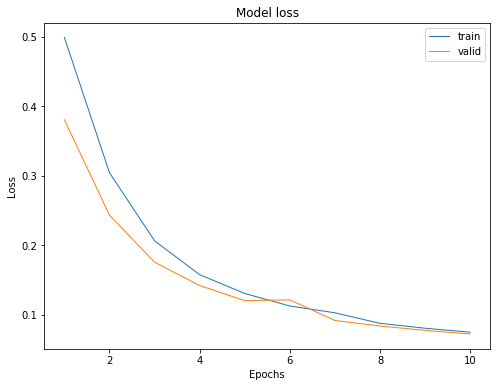

In [147]:
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='train', linewidth=1)
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='valid', linewidth=1)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')
plt.show()

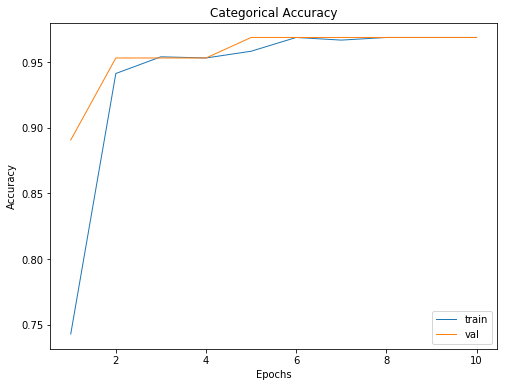

In [148]:
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='train', linewidth=1)
plt.plot(range(1, len(valid_accuracies)+1), valid_accuracies, label='valid', linewidth=1)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Categorical Accuracy')
plt.show()

In [149]:
test_loss, test_accuracy = testModel(test_loader, criterion, False)
print('Test Loss: {:.4f}\tTest Accuracy: {:.4f}'.format(test_loss, test_accuracy))

Test Loss: 0.0724	Test Accuracy: 0.9688
